## Import libraries

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score

%matplotlib inline

## Read in data

In [2]:
housing = pd.read_csv('data/boston_house_prices.csv')
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Update to a cross-validated approach


### TODO:
[x] Do a train-test split
[x] Do cross-validation and regularization
[ ] Estimate parameters using Bootstrapping

### Note about Github:

Generally we _don't_ write comments in code such as "replaced linear regression". We could, but if we use git logging system we should be able to tell what changed and revert back to it quickly.

In [3]:
features = housing.drop('MEDV', axis=1)
target = housing['MEDV']

In [4]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                           random_state=42)

In [18]:
scaler = RobustScaler()
lasso_regressor = LassoCV(cv=5)
features_train_scaled = scaler.fit_transform(features_train)
lasso_regressor.fit(features_train_scaled, target_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [19]:
lasso_regressor.alpha_

0.013523912601697196

In [20]:
predicted_train = lasso_regressor.predict(features_train_scaled)

r2_score(target_train, predicted_train)

0.7476772200390822

Our Linear Regression $R^2$ was 0.740642664; moving to Lasso has (surprisingly) done a little better. Note that the Linear Regression model was on all data, and the prediction above is on 70% of the data; they are close and it is possible an outlier could swing the result. 

We generally expect this (i.e. to do worse on the training set when we have regularization). The point of regularization is to do worse on the training set by making overfitting more difficult; hopefully we do better on the test set as a result and our model generalizes better. 

Let's look at the test set and see if this is the case:

In [21]:
features_test_scaled = scaler.transform(features_test)
predicted_test = lasso_regressor.predict(features_test_scaled)
r2_score(target_test, predicted_test)

0.6822695353978907

Ouch! 

This is signficantly worse than the adjusted R^2 from Excel! Still an improvement from when we forgot to scale.

Now that we have scaled, we can trust the results of our coefficients more.

While working on this, let's look at the coefficients of the `lasso_regressor`. It is common to use lasso (aka L1 regression) to do feature selection, as it tends to set the coefficients of unimportant features to zero (at least more aggressively than ridge does).

In [22]:
lasso_regressor.coef_

array([-0.39396364,  0.52019856,  0.24407391,  2.65783422, -2.80435801,
        3.40274696, -0.34031196, -4.25642727,  2.54674046, -2.86232546,
       -3.25388688,  0.25833119, -4.93339606])

None of the coefficients were chosen as unimportant, i.e. Lasso set none of the coefficients to zero. After scaling, the coefficients are more or less comparable. Let's get a ranking of the most important features: 

In [23]:
feature_importance = sorted(zip(lasso_regressor.coef_, features.columns), key=lambda x: abs(x[0]),
                           reverse=True)
for coef, name in feature_importance:
    print(f'{name:10s} {coef:6.4f}')

LSTAT      -4.9334
DIS        -4.2564
RM         3.4027
PTRATIO    -3.2539
TAX        -2.8623
NOX        -2.8044
CHAS       2.6578
RAD        2.5467
ZN         0.5202
CRIM       -0.3940
AGE        -0.3403
B          0.2583
INDUS      0.2441


## Plot of residuals

In Excel, we include a plot of residuals for every feature. We will do the same thing here

In [24]:
# Note this definition of residuals is actually off by a minus sign
# We will correct this in a later commit - this is a deliberate "mistake"
residuals = predicted_train - target_train

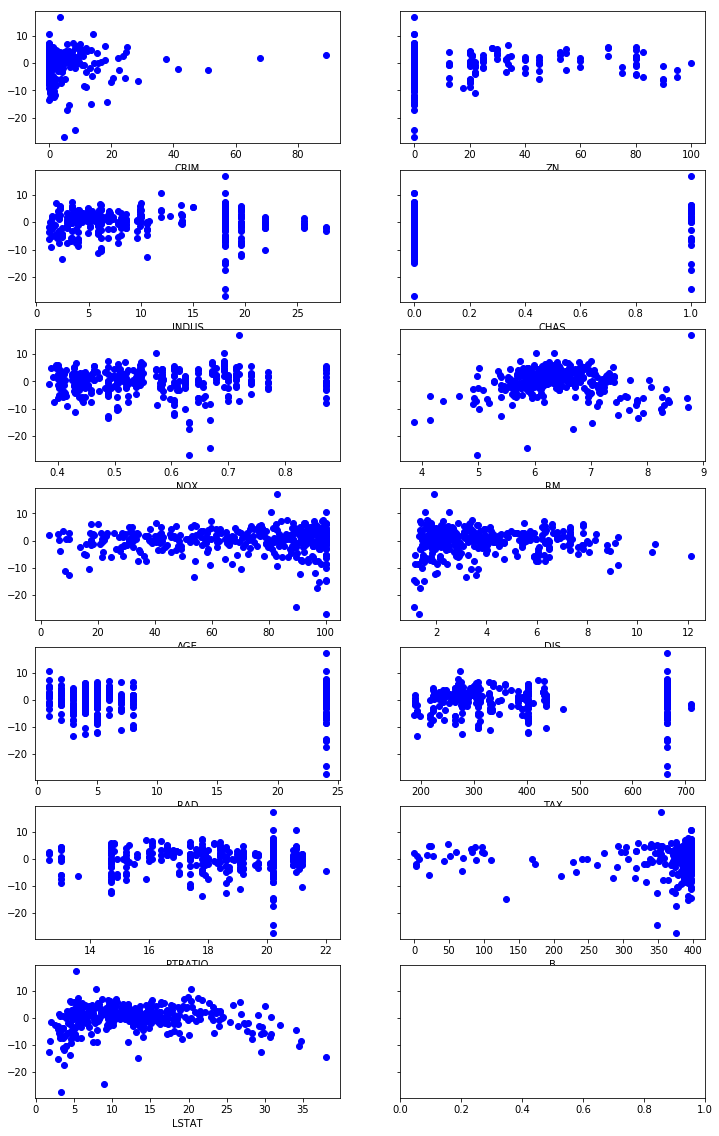

In [25]:
fig, axes = plt.subplots(ncols=2, nrows=len(features.columns)//2 + 1, 
                         sharey=True, squeeze=True, figsize=(12,20))

for index, feature_name in enumerate(features_train.columns):
    feature_values = features_train[feature_name]
    col = index % 2
    row = index // 2
    this_plot = axes[row][col]
    this_plot.plot(feature_values, residuals, 'bo')
    this_plot.set_xlabel(feature_name)